Don't forget to run IRkernel::installspec() in R in order to let the jupyter recongize the R kernel before running the notebook.

## Visualisation of HTODemux result

In [1]:
library(data.table) 
library(plyr)
library(Seurat)
library(ggplot2)
library(repr)

Attaching SeuratObject



In [2]:
# Load htodemux result from an rds object
htodemux_gx12 <- readRDS("../data/pipeline_output/gx12/htodemux.rds")

### UMAP plot

Warning message:
“Requested number is larger than the number of available items (6). Setting to 6.”
Warning message:
“Requested number is larger than the number of available items (6). Setting to 6.”
Warning message:
“Requested number is larger than the number of available items (6). Setting to 6.”
Warning message:
“Requested number is larger than the number of available items (6). Setting to 6.”
Warning message:
“Requested number is larger than the number of available items (6). Setting to 6.”
PC_ 1 
Positive:  Hash453-TotalSeqA, Hash452-TotalSeqA, Hash451-TotalSeqA 
Negative:  Hash454-TotalSeqA, Hash455-TotalSeqA, Hash456-TotalSeqA 
PC_ 2 
Positive:  Hash456-TotalSeqA, Hash455-TotalSeqA, Hash454-TotalSeqA 
Negative:  Hash452-TotalSeqA, Hash451-TotalSeqA, Hash453-TotalSeqA 
PC_ 3 
Positive:  Hash451-TotalSeqA, Hash454-TotalSeqA, Hash456-TotalSeqA 
Negative:  Hash452-TotalSeqA, Hash453-TotalSeqA, Hash455-TotalSeqA 
PC_ 4 
Positive:  Hash456-TotalSeqA, Hash454-TotalSeqA, Hash453-TotalSe

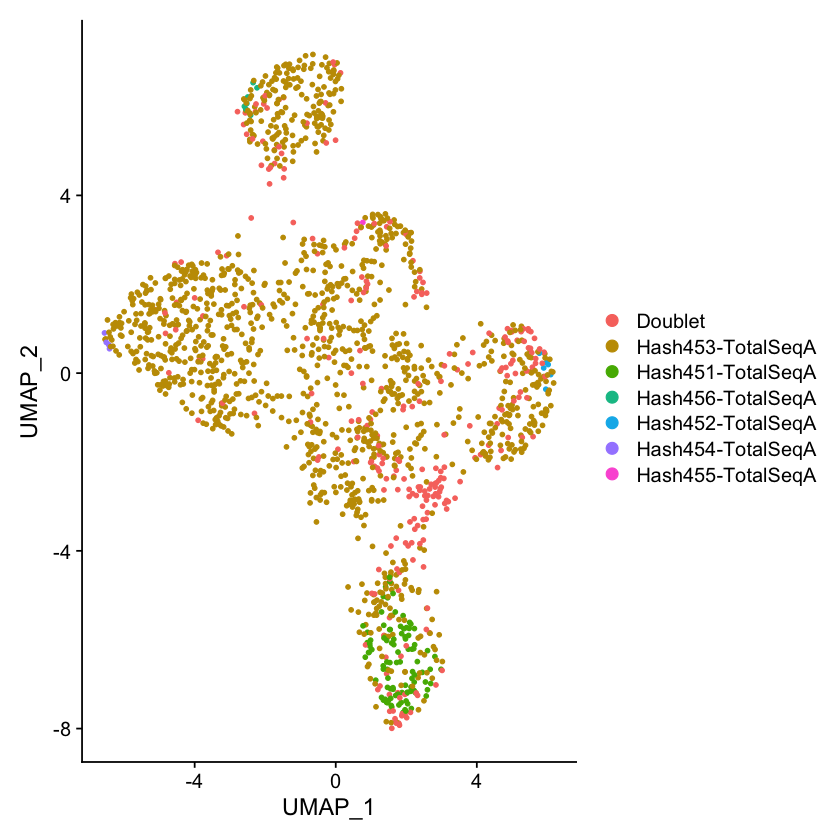

In [3]:
# Subset the object, remove negative droplets
htodemux_gx12.subset <- subset(htodemux_gx12, idents = "Negative", invert = TRUE)

# Calculate a UMAP embedding of the HTO data
DefaultAssay(htodemux_gx12.subset) <- "HTO"
htodemux_gx12.subset <- ScaleData(htodemux_gx12.subset, features = rownames(htodemux_gx12.subset),
    verbose = FALSE)
htodemux_gx12.subset <- RunPCA(htodemux_gx12.subset, features = rownames(htodemux_gx12.subset), approx = FALSE)

htodemux_gx12.subset <- RunUMAP(htodemux_gx12.subset, dims = 1:6)
DimPlot(htodemux_gx12.subset,reduction = "umap") 

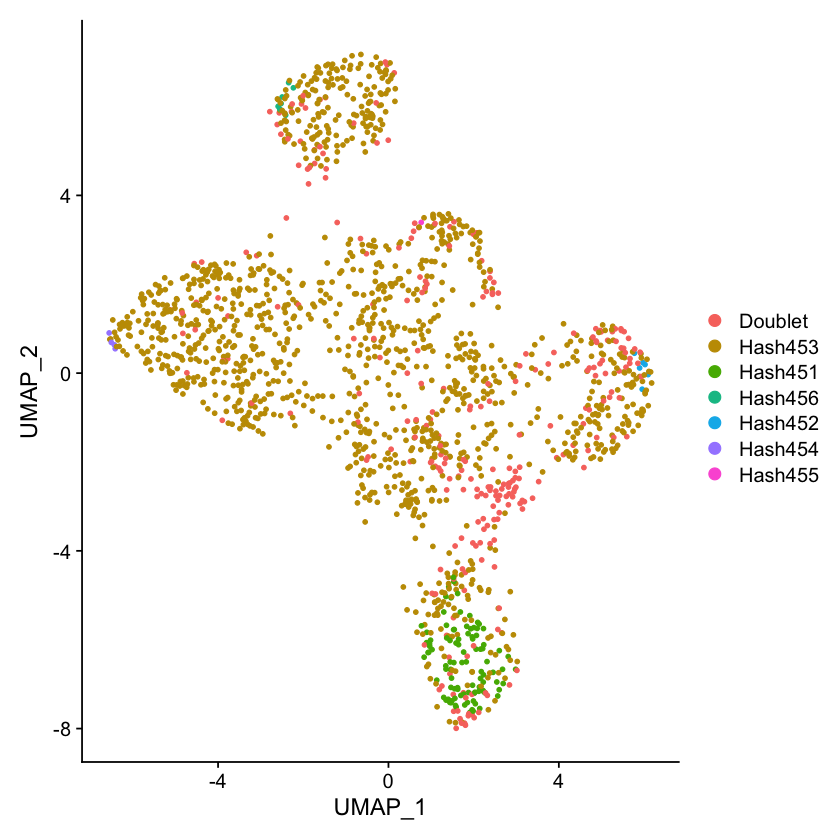

In [4]:
DimPlot(htodemux_gx12.subset,reduction = "umap") + 
    scale_color_hue(labels = c("Doublet", paste0("Hash45", c(3,1,6,2,4,5))))
# ggsave("umap_gx12.png", dpi = 300, height = 5, width = 5)

### Violin plot

In [5]:
# Rename features
htodemux_gx12[["HTO"]]@counts@Dimnames[[1]] <- paste0("Hash45", 1:6)
dimnames(htodemux_gx12[["HTO"]]@data)[[1]] <- paste0("Hash45", 1:6)
htodemux_gx12 <- RenameIdents(htodemux_gx12, 'Hash453-TotalSeqA' = 'Hash453', 'Hash451-TotalSeqA' = 'Hash451', 'Hash452-TotalSeqA' = 'Hash452', 'Hash454-TotalSeqA' = 'Hash454',
    'Hash455-TotalSeqA' = 'Hash455', 'Hash456-TotalSeqA' = 'Hash456')

htodemux_gx12[["HTO_classification"]]$HTO_classification <- gsub('-TotalSeqA', '', htodemux_gx12[["HTO_classification"]]$HTO_classification)

# raw counts
counts_raw <- t(as.matrix(htodemux_gx12[["HTO"]]@counts))
counts_raw <- melt(counts_raw)
colnames(counts_raw) <- c("Cell", "Hashtag", "Expression")
head(counts_raw)

Warning message in melt(counts_raw):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(counts_raw). In the next version, this warning will become an error.”


,Cell,Hashtag,Expression
,<fct>,<fct>,<dbl>
1,AAACCCAAGGTGTGAC-1,Hash451,208
2,AAACCCAGTGAGAGGG-1,Hash451,148
3,AAACGAAAGAATCTAG-1,Hash451,208
4,AAACGAACACATATGC-1,Hash451,190
5,AAACGAACACGACTAT-1,Hash451,203
6,AAACGAACATCAGCAT-1,Hash451,191


In [6]:
cutoff <- data.frame(Hashtag = paste0("Hash45", 1:6), slope_value = c(311, 121, 596, 10, 32, 98)) # extract from htodemux
cutoff$Hashtag <- as.factor(cutoff$Hashtag)
cutoff

Hashtag,slope_value
<fct>,<dbl>
Hash451,311
Hash452,121
Hash453,596
Hash454,10
Hash455,32
Hash456,98


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


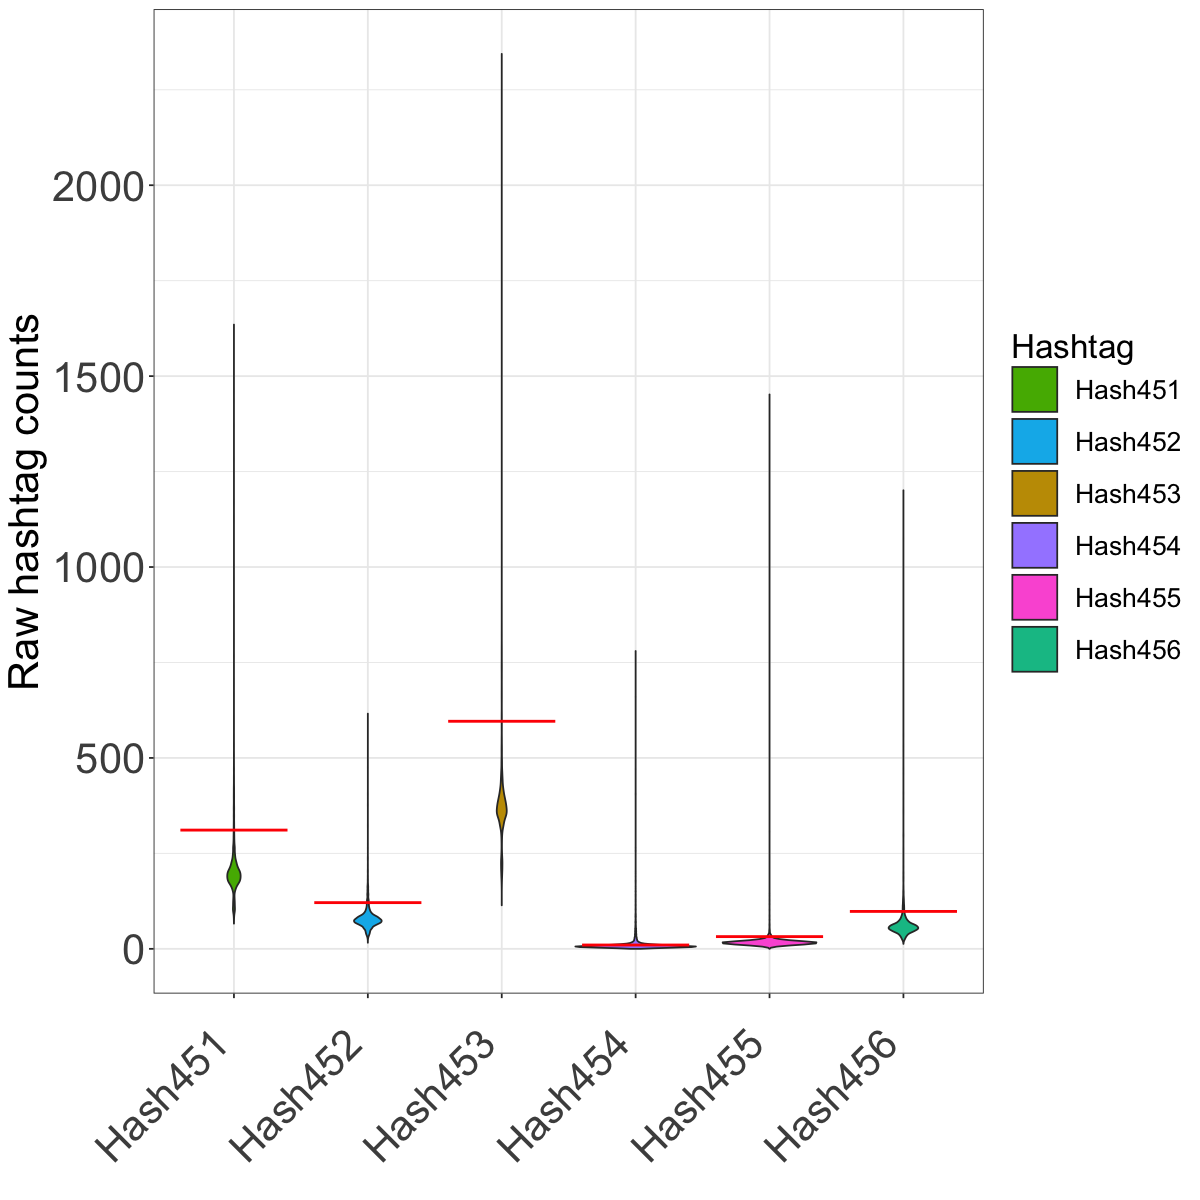

In [7]:
options(repr.plot.width=10, repr.plot.height=10)

ggplot(counts_raw, aes(x=Hashtag,y=Expression, fill=Hashtag)) + 
    geom_violin() + xlab("") + ylab("Raw hashtag counts") + 
    scale_fill_manual(values = c('#53B400', '#00B6EB', '#C49A00','#A58AFF','#FB61D7','#00C094')) + 
    geom_segment(data = cutoff, inherit.aes = FALSE, aes(x = as.numeric(Hashtag) -0.4, xend = as.numeric(Hashtag) + 0.4,
    yend = slope_value, y = slope_value), colour="red", size = 0.8) + theme_bw() +
    theme(axis.text.y=element_text(size=25),
        axis.text.x=element_text(size=25, angle = 45, hjust = 1.2), axis.title=element_text(size=25),        
        legend.title = element_text(size=20),
        legend.text = element_text(size=16),
        legend.key.size = unit(1, 'cm'),
        legend.spacing.y = unit(0.1, 'cm')) + guides(fill = guide_legend(byrow = TRUE))
#ggsave("Figure2.1_violin_plot.pdf", width= 10, height=10, dpi=300)
    

## Visualisation of hashing deconvolution results

In [8]:
# Load hashing deconvolution results
hash_gx12_classi <-fread("../data/pipeline_output/gx12/hash_classification_all.csv")

# Remove the trial ID
colnames(hash_gx12_classi) <- gsub("_1", "", colnames(hash_gx12_classi))

# Subset by only those cells detected by RNA
white_list_gx12 <- fread("../data/dataset/barcodes_gx12.tsv", header = F)$V1
hash_gx12_classi <- hash_gx12_classi[Barcode %in% white_list_gx12,]

# remove doublet detection method solo
hash_gx12_classi <- hash_gx12_classi[,1:6]
head(hash_gx12_classi)

Barcode,demuxem,hashedDrops,hashsolo,htodemux,multiseq
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AAACCCAAGGTGTGAC-1,singlet,negative,singlet,singlet,singlet
AAACCCAGTGAGAGGG-1,singlet,NA,singlet,negative,doublet
AAACGAAAGAATCTAG-1,negative,negative,singlet,negative,negative
AAACGAACACATATGC-1,singlet,negative,singlet,negative,negative
AAACGAACACGACTAT-1,singlet,negative,singlet,singlet,singlet
AAACGAACATCAGCAT-1,negative,negative,singlet,singlet,negative


In [9]:
# Reorder the result
summary_hash_gx12 <- melt(hash_gx12_classi, id.vars = "Barcode", variable.name = "Method", 
                          value.name = "Classification")
summary_hash_gx12 <- na.omit(summary_hash_gx12)
summary_hash_gx12 <- as.data.frame(table(summary_hash_gx12[,-1]))
colnames(summary_hash_gx12)[3] <- "Count" 
summary_hash_gx12 <- summary_hash_gx12[order(summary_hash_gx12$Classification, decreasing = T),]
head(summary_hash_gx12)

,Method,Classification,Count
,<fct>,<fct>,<int>
11,demuxem,singlet,1812
12,hashedDrops,singlet,32
13,hashsolo,singlet,4686
14,htodemux,singlet,1402
15,multiseq,singlet,1853
6,demuxem,negative,2262


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


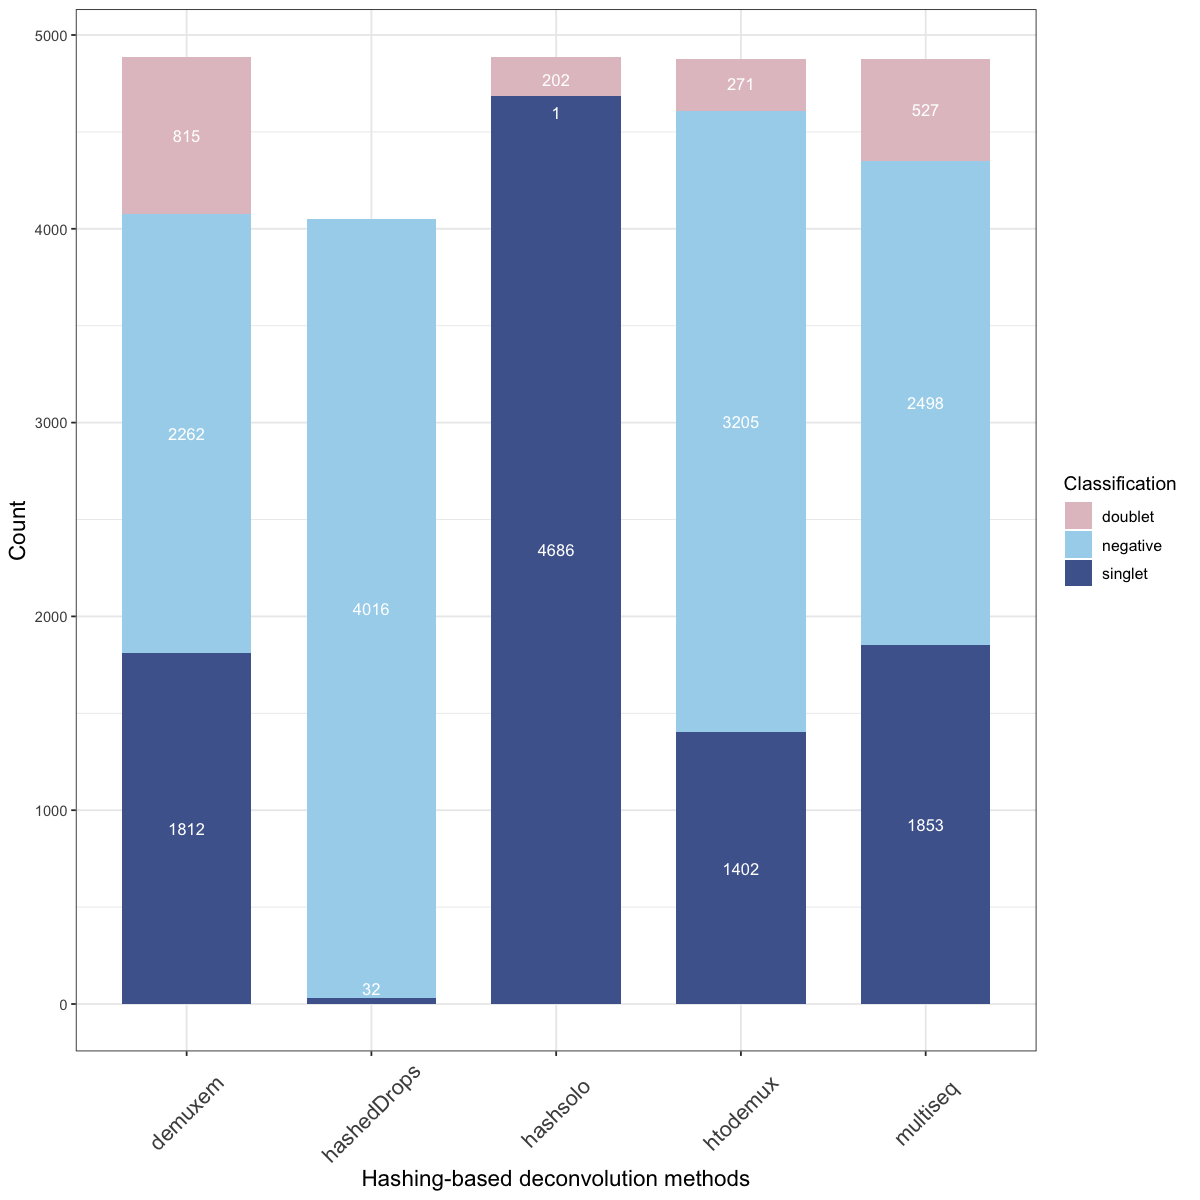

In [10]:
# Determine the y-axis position of labels ylab_pos
summary_hash_gx12_cumsum <- ddply(summary_hash_gx12, "Method", transform, label_ypos=cumsum(Count)- 0.5*Count)

# Modify the ylab_pos manually
summary_hash_gx12_cumsum[summary_hash_gx12_cumsum$Method=="hashsolo" & 
                         summary_hash_gx12_cumsum$Classification=="doublet",]$label_ypos <- 4770
summary_hash_gx12_cumsum[summary_hash_gx12_cumsum$Method=="hashsolo" & 
                         summary_hash_gx12_cumsum$Classification=="negative",]$label_ypos <- 4600
summary_hash_gx12_cumsum[summary_hash_gx12_cumsum$Method=="htodemux" & 
                         summary_hash_gx12_cumsum$Classification=="doublet",]$label_ypos <- 4750
summary_hash_gx12_cumsum[summary_hash_gx12_cumsum$Method=="hashedDrops" & 
                         summary_hash_gx12_cumsum$Classification=="singlet",]$label_ypos <- 80

# Avoid showing count 0
summary_hash_gx12_cumsum[summary_hash_gx12_cumsum$Count==0,]$label_ypos <- NA

# Barplot
ggplot(summary_hash_gx12_cumsum, aes(x=Method, y=Count, fill=Classification)) +
  geom_bar(stat="identity", width=0.7) + scale_fill_manual(values = c("#E2C3C9", "#a6d5ed", "#4e659b")) + 
  theme_bw() + theme(axis.title=element_text(size=13.5)) + xlab("Hashing-based deconvolution methods") +
  geom_text(aes(y=label_ypos, label=Count), vjust=0.5, color="white", size=3.5) +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5, size = 13), legend.text=element_text(size=9.5),
  legend.title=element_text(size=11.5))

# ggsave("hash_bar_gx12.png", dpi = 300, height = 6, width = 7)

## Visualisation of genetic deconvolution results

In [11]:
# Load genetic demultiplexing results
gene_gx12_classi <-fread("../data/pipeline_output/gx12/genetic_classification_all.csv")

# Remove the trial ID
colnames(gene_gx12_classi) <- gsub("_1", "", colnames(gene_gx12_classi))

# Reorder the result
summary_gene_gx12 <- melt(gene_gx12_classi, id.vars = "Barcode", variable.name = "Method", 
                          value.name = "Classification")
summary_gene_gx12 <- na.omit(summary_gene_gx12)
summary_gene_gx12 <- as.data.frame(table(summary_gene_gx12[,-1]))
colnames(summary_gene_gx12)[3] <- "Count" 
summary_gene_gx12 <- summary_gene_gx12[order(summary_gene_gx12$Classification, decreasing = T),]
head(summary_gene_gx12)

,Method,Classification,Count
,<fct>,<fct>,<int>
9,freemuxlet,singlet,4590
10,scsplit,singlet,4445
11,souporcell,singlet,4465
12,vireo,singlet,4377
5,freemuxlet,negative,7
6,scsplit,negative,0


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


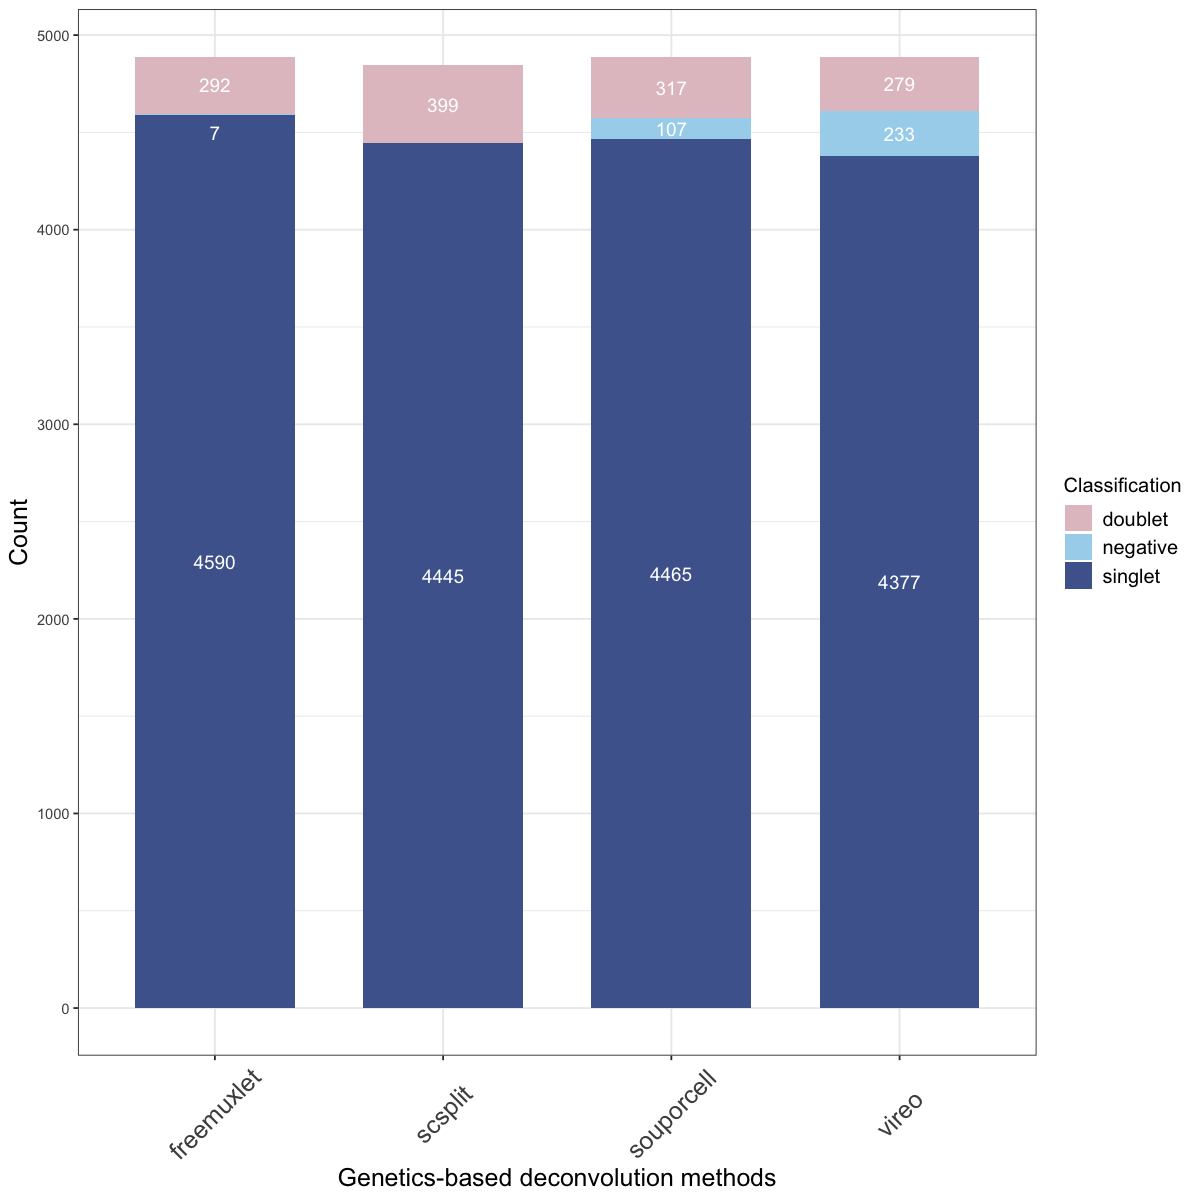

In [12]:
# Determine the y-axis position of labels ylab_pos
summary_gene_gx12_cumsum <- ddply(summary_gene_gx12, "Method", transform, 
                                  label_ypos=cumsum(Count)- 0.5*Count)

# Avoid showing count 0
summary_gene_gx12_cumsum[summary_gene_gx12_cumsum$Count==0,]$label_ypos <- NA

# Modify the ylab_pos manually
summary_gene_gx12_cumsum[summary_gene_gx12_cumsum$Method=="freemuxlet" & 
                         summary_gene_gx12_cumsum$Classification=="negative",]$label_ypos <- 4500

# Barplot
ggplot(summary_gene_gx12_cumsum, aes(x=Method, y=Count, fill=Classification)) +
    geom_bar(stat="identity", width=0.7) + scale_fill_manual(values = c("#E2C3C9", "#a6d5ed", "#4e659b")) + 
    theme_bw() + theme(axis.title=element_text(size=15)) + xlab("Genetics-based deconvolution methods") +
    geom_text(aes(y=label_ypos, label=Count), vjust=0.5, color="white", size=4) +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5, size = 15),
    legend.text=element_text(size=12),
    legend.title=element_text(size=12))

# ggsave("gene_bar_gx12.png", dpi = 300, height = 5, width = 7)